result.shape 1  torch.Size([3, 544, 960])
resized_img.shape torch.Size([3, 544, 960])
s time : 1.6927719116210938e-05
result torch.Size([1566720]) torch.float32
self.out_shape [(24480,), (6120,)]
output_datas[0].shape torch.Size([24480]) torch.Size([6120])
bindings [140570913208320, 140570913306624]
bindings [140570863312896, 140570913208320, 140570913306624]
[1.0877376  1.67242    2.841372   ... 0.5986968  0.43259037 0.61556065] (24480,)
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.7881393e-07
 3.8743019e-07] (6120,)
boxes [1.0877376  1.67242    2.841372   ... 0.5986968  0.43259037 0.61556065] 24480
boxes [1.0877376  1.67242    2.841372   ... 0.5986968  0.43259037 0.61556065] 24480
boxes [1.0877376  1.67242    2.841372   ... 0.5986968  0.43259037 0.61556065] 24480
outputs_lsit [[663, 77, 71, 86, 0.9997161030769348, 2]]
outputs_lsit [[663, 77, 71, 86, 0.9997161030769348, 2], [438, 61, 82, 96, 0.9995859861373901, 2]]
outputs_lsit [[663, 77, 71, 86, 0.9997161030769348, 

[TensorRT] WARNING: Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
[TensorRT] WARNING: TensorRT was linked against cuDNN 8.2.1 but loaded cuDNN 8.2.0
[TensorRT] WARNING: TensorRT was linked against cuDNN 8.2.1 but loaded cuDNN 8.2.0


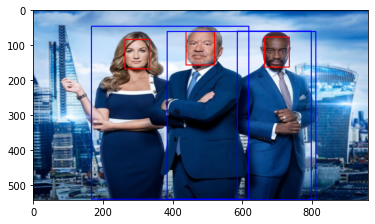

In [4]:
import argparse
import os
import sys
import numpy as np
import tensorrt as trt
import cv2
import torchvision
import torch
import time
import traceback
import importlib
import common
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.init()



def applyBoxNorm(o1, o2, o3, o4, x, y):
    """
    Applies the GridNet box normalization
    Args:
        o1 (float): first argument of the result
        o2 (float): second argument of the result
        o3 (float): third argument of the result
        o4 (float): fourth argument of the result
        x: row index on the grid
        y: column index on the grid

    Returns:
        float: rescaled first argument
        float: rescaled second argument
        float: rescaled third argument
        float: rescaled fourth argument
    """
    o1 = (o1 - grid_centers_w[x]) * -box_norm
    o2 = (o2 - grid_centers_h[y]) * -box_norm
    o3 = (o3 + grid_centers_w[x]) * box_norm
    o4 = (o4 + grid_centers_h[y]) * box_norm
    return o1, o2, o3, o4

def NMSBoxes(bboxes,scores,class_ids, outputs_lsit):
    indexes = cv2.dnn.NMSBoxes(bboxes, scores, threshold, 0.5)
    for idx in indexes:
        idx = int(idx)
        xmin, ymin, xmax, ymax = bboxes[idx]
        class_id = class_ids[idx]
        score = scores[idx]
        result = [xmin, ymin, xmax, ymax,score,class_id]
        outputs_lsit.append(result)
        print('outputs_lsit',outputs_lsit)
    return outputs_lsit

def postprocess(outputs, min_confidence, analysis_classes, wh_format=True):
    """
    Postprocesses the inference output
    Args:
        outputs (list of float): inference output
        min_confidence (float): min confidence to accept detection
        analysis_classes (list of int): indices of the classes to consider

    Returns: list of list tuple: each element is a two list tuple (x, y) representing the corners of a bb
    """
    outputs_lsit = list()

    bbs = []
    class_ids = []
    scores = []
    for c in analysis_classes:

        x1_idx = c * 4 * grid_size
        y1_idx = x1_idx + grid_size
        x2_idx = y1_idx + grid_size
        y2_idx = x2_idx + grid_size

        boxes = outputs[0]
        print('boxes',boxes, len(boxes))
        for h in range(grid_h):
            for w in range(grid_w):
                i = w + h * grid_w
                score = outputs[1][c * grid_size + i]
                if score >= min_confidence:
                    o1 = boxes[x1_idx + w + h * grid_w]
                    o2 = boxes[y1_idx + w + h * grid_w]
                    o3 = boxes[x2_idx + w + h * grid_w]
                    o4 = boxes[y2_idx + w + h * grid_w]

                    o1, o2, o3, o4 = applyBoxNorm(o1, o2, o3, o4, w, h)

                    xmin = int(o1)
                    ymin = int(o2)
                    xmax = int(o3)
                    ymax = int(o4)
                    if wh_format:
                        bbs.append([xmin, ymin, xmax - xmin, ymax - ymin])
                    else:
                        bbs.append([xmin, ymin, xmax, ymax])
                    class_ids.append(c)
                    scores.append(float(score))
    outputs_lsit = NMSBoxes(bbs,scores,class_ids,outputs_lsit)
    return bbs, class_ids, scores

# img_path = '/DATA_17/ij/test/image.png'
img_path = '/DATA_17/ij/test/test_image.jpeg'
image = cv2.imread(img_path)[..., ::-1]
# image = cv2.imread(img_path)#BGR 순서를 RGB로 뒤집습니다.
image = np.copy(image)
image = torch.from_numpy(image).to(torch.device("cuda"))
# img = torch.from_numpy(img).to(torch.device("cuda")) 
image = image.permute(2,0,1)
frame_batch = [image]
input_h = 544
input_w = 960
#####################################################################################################

# result = torch.zeros([len(frame_batch), 3, input_h, input_w], dtype=torch.float32, device=torch.device("cuda")).fill_(144)

# scale_list = []
# for idx, frame in enumerate(frame_batch) :

#     _, h, w = frame.shape

#     r = min(input_h/h, input_w/w)
#     if r < 1 :  
#         rw, rh = int(r*w), int(r*h)

#         resized_img = torchvision.transforms.functional.resize(frame, (rh,rw)).float()
#         result[idx, :,:rh,:rw] = resized_img 
#         scale_list.append(r)
#     else : 

#         result[idx, :,:h,:w] = frame
#         scale_list.append(None)

        
# # result = torch.ravel(result)

# print('result.shape',result.shape)
#####################################################################################################
result = torch.zeros([3, input_h, input_w], dtype=torch.float32, device=torch.device("cuda")).fill_(144)
# result = torch.zeros([3*input_h*input_w], dtype=torch.float32, device=torch.device("cuda")).fill_(144)
print('result.shape 1 ',result.shape)

scale_list = []
for idx, frame in enumerate(frame_batch) :

    _, h, w = frame.shape
    

    r = min(input_h/h, input_w/w)
#     if r < 1 :  
#         rw, rh = int(r*w), int(r*h)
#         print('frame.shape',frame.shape)
#         resized_img = torchvision.transforms.functional.resize(frame, (rh,rw)).float()
#         resized_img = resized_img.div(255.0)
#         print('resized_img.shape',resized_img.shape)
#         result[:,:rw,:rw] = resized_img 
#         result = torch.ravel(result)
#         scale_list.append(r)
#     else : 
#     print(frame)
#     frame = frame[..., :-1:]
#     print(frame)
    resized_img = torchvision.transforms.functional.resize(frame, (input_h,input_w)).float()
    resized_img = resized_img.div(255.0)
    print('resized_img.shape',resized_img.shape)
    result[:,:input_h,:input_w] = resized_img
    s = time.time()
    result = torch.ravel(result)
    print(f's time : {time.time()-s}')
    scale_list.append(None)
        
print('result',result.shape, result.dtype)

############3
# print('image 123 ',image.shape, image.dtype)
# image = Image.fromarray(np.uint8(image))

# image_resized = image.resize(size=(input_w, input_h), resample=Image.BILINEAR)
# img_np = np.array(image_resized)
# # HWC -> CHW
# img_np = img_np.transpose((2, 0, 1))
# # Normalize to [0.0, 1.0] interval (expected by model)
# img_np = (1.0 / 255.0) * img_np
# print('img_np111',img_np.shape, img_np.dtype)


# # img_np = img_np.ravel()
# # print('img_np',img_np.shape, img_np.dtype)
# result = torch.from_numpy(img_np).to(torch.device("cuda"))
# result = torch.ravel(result)
# result = result.type(torch.float32)
# print('result',result.shape, result.dtype)
# # result = torch.ravel(result)

# print('result.shape',result.shape)
###########3
# print('detection_out',detection_out,'keepCount_out',keepCount_out)
NUM_CLASSES = 3
threshold = 0.3


model_h = 544
model_w = 960
# stride = 16
# box_norm = 35.0
stride = 16
box_norm = 35.0

grid_h = int(model_h / stride)
grid_w = int(model_w / stride)
grid_size = grid_h * grid_w

grid_centers_w = []
grid_centers_h = []

for i in range(grid_h):
    value = (i * stride + 0.5) / box_norm
    grid_centers_h.append(value)

for i in range(grid_w):
    value = (i * stride + 0.5) / box_norm
    grid_centers_w.append(value)


    
weights = '/DATA_17/ij/test/resnet34_peoplenet_pruned.etlt_b1_gpu0_fp32.engine'
# weights = '/DATA_17/trt_test/engines/yoloxm_816_fp16/yoloxm_fp16_016.trt'

Engine = common.Engine()      
Engine.make_context(weights)


[detection_out, keepCount_out] = Engine.do_inference_v2(result)    
# detection_out = torch.ravel(detection_out)
# keepCount_out = torch.ravel(keepCount_out)
detection_out = detection_out.detach().cpu()
keepCount_out = keepCount_out.detach().cpu()
detection_out = np.array(detection_out)
keepCount_out = np.array(keepCount_out)

print(detection_out,detection_out.shape)
print(keepCount_out,keepCount_out.shape)
bboxes, class_ids, scores = postprocess([detection_out, keepCount_out], threshold, list(range(NUM_CLASSES)))

image = cv2.imread(img_path)[..., ::-1]
image_cpy = image.copy()
image_cpy = cv2.resize(image_cpy, (model_w, model_h))

# Final bboxes only take afet NMS

indexes = cv2.dnn.NMSBoxes(bboxes, scores, threshold, 0.5)
print('indexes',indexes)
for idx in indexes:
    idx = int(idx)
    xmin, ymin, w, h = bboxes[idx]
    class_id = class_ids[idx]
    print(f'class_id : {class_id}, xmin, ymin, w, h : {xmin, ymin, w, h}')
    color = [255, 0, 0] if class_id else [0, 0, 255]
    cv2.rectangle(image_cpy, (xmin, ymin), (xmin + w, ymin + h), color, 2)
plt.imshow(image_cpy)
plt.show()

